# Model Refinement

![Docent of Perfection](http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=414349&type=card)
![Final Iteration](http://gatherer.wizards.com/Handlers/Image.ashx?multiverseid=414350&type=card)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from model.master_transmuter import *
from model.models import *
from scrape.scraper import *
from query import *
from unit_tests import *

## Adding type, color dummies to features

In [2]:
rarity = 'mythic'
raw_df = pd.read_csv('data/all_vintage_cards-{}_recent.csv'.format(rarity))

# drop sets, drop duplicates, set indices
X, y = csv_cleaner(raw_df)
# y = y*100
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [9]:
pipe, results_df, model_score = fit_refine_pipeline(X_train, X_test, y_train, y_test)
print('{0} refined features score: {1}'.format(rarity,model_score))

dummy_results_df, baseline_score = baseline_model(X_train, X_test, y_train, y_test)
print('{0} basline (log mean) score: {1}'.format(rarity,baseline_score))

print('Model improvement over baseline (log mean score): {}'.format(baseline_score-model_score))

print('Worst predicted cards :')
results_df[['cardname','setname','y_pred','y_test','log_diff']].sort_values('log_diff', ascending=False).head(10)

mythic refined features score: 0.9269400691908918
mythic basline (log mean) score: 1.023922304320757
Model improvement over baseline (log mean score): 0.09698223512986526
Worst predicted cards :


,cardname,setname,y_pred,y_test,log_diff
id,,,,,
0e606072-a3aa-4300-ba90-ec92a721fa76,"Jace, the Mind Sculptor",Worldwake,3.7,92.8,2.993602
5d10b752-d9cb-419d-a5c4-d4ee1acb655e,"Teferi, Hero of Dominaria",Dominaria,3.9,47.0,2.281966
3bd78731-949c-464a-826a-92f86d784911,Carnage Tyrant,Ixalan,3.3,31.0,2.007121
d5b92a6f-d1f5-4094-8174-88dbc47d9b5c,Wurmcoil Engine,Commander 2014,2.0,17.2,1.802809
266e5267-2288-4bb0-8c54-0c556521cec3,Temporal Mastery,Avacyn Restored,1.2,11.1,1.704748
f06fc6e0-b22c-40d3-bb53-d5ec400d921c,"Kozilek, the Great Distortion",Oath of the Gatewatch,30.0,4.8,1.676129
95ff5e62-b73e-4b85-b65f-5226e75c7f97,Risen Executioner,Dragons of Tarkir,11.2,1.3,1.668527
f7f99431-ae43-4b68-82f0-faf940216c91,Dragon Broodmother,Alara Reborn,2.0,14.4,1.635755
94002868-a48a-4ea8-bfce-17257078f5db,Ugin's Nexus,Khans of Tarkir,5.4,0.3,1.593934


Observations:

* Planeswalkers harder to predict, possibly due to small sample size to test on, less punishment for missing higher cost cards due to logging (maybe logging y is bad?)

* Carnage Tyrant, wurmcoil engine only good because of keywords and abilities; not parsed yet

* Temporal Mastery and Kozilek missed due to high casting cost and importance of cmc to model

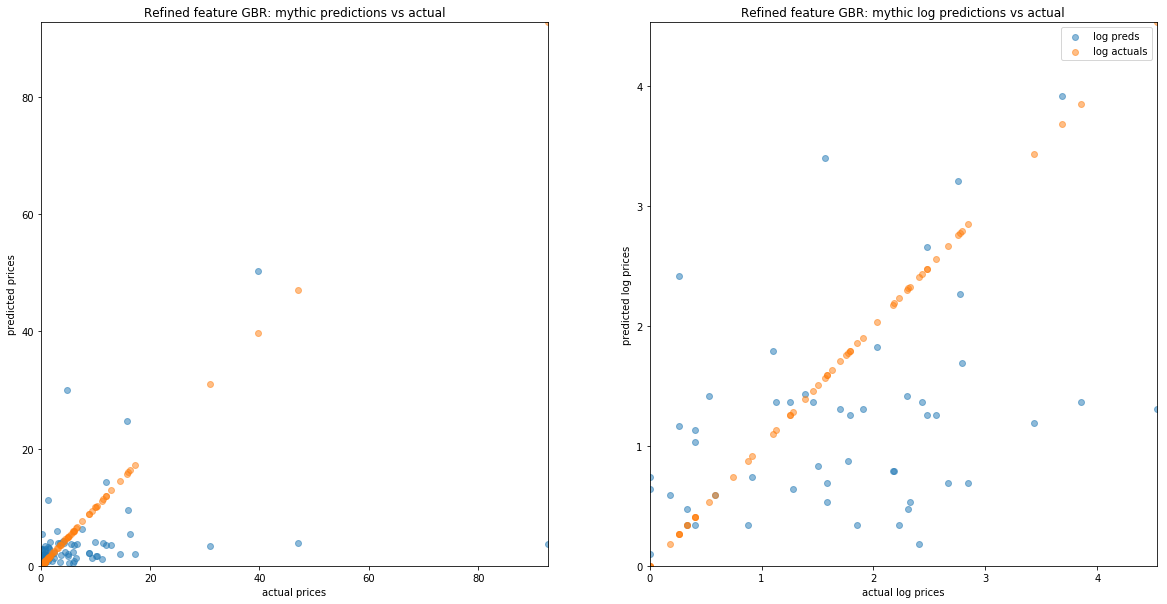

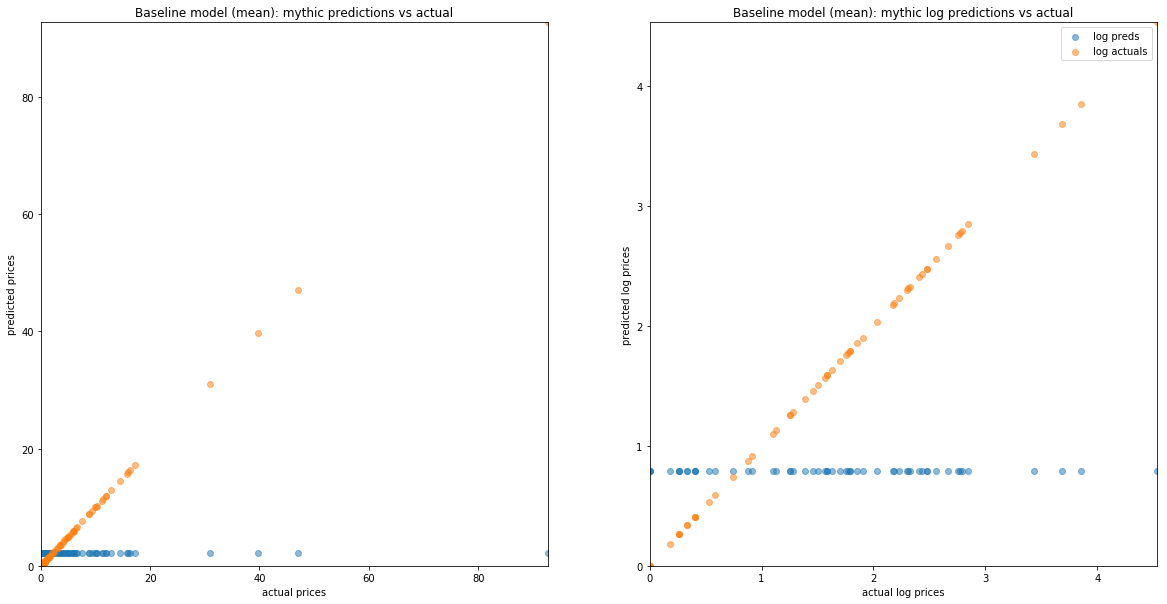

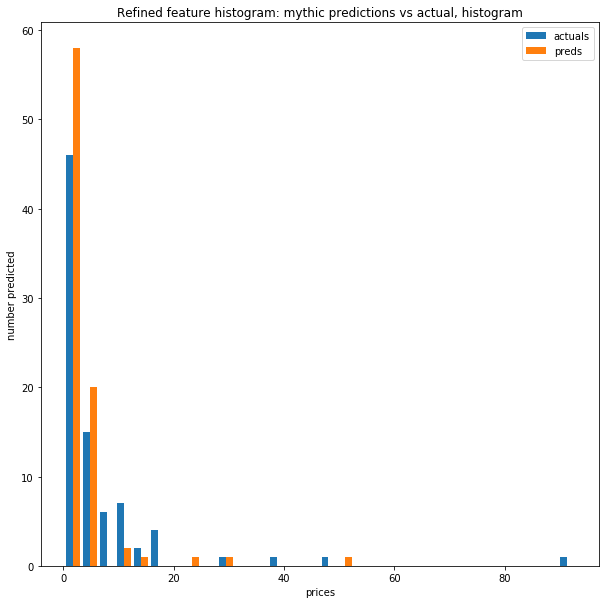

In [10]:
plot_residuals(results_df['y_pred'],results_df['y_test'], 'Refined feature GBR: '+rarity)
plot_residuals(dummy_results_df['y_pred'],dummy_results_df['y_test'], 'Baseline model (mean): '+rarity)
plot_pred_hist(results_df['y_pred'],results_df['y_test'], 'Refined feature histogram: '+rarity)